In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Resizing, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.saving import load_model

In [3]:
from sklearn.metrics import classification_report, confusion_matrix

### Exploratory Analysis and Visualization

In [4]:
data_path = '/home/alvaro/tf_templates/DATA/cell_images'
train_path = os.path.join(data_path, 'train')
test_path = os.path.join(data_path, 'test')

In [5]:
os.listdir(train_path)

['uninfected', 'parasitized']

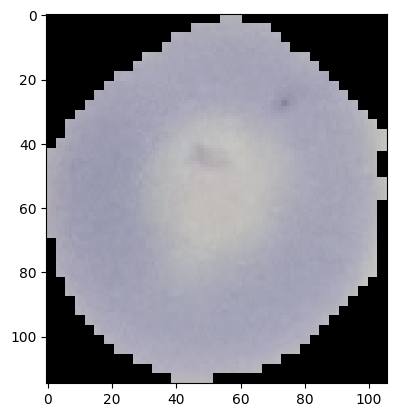

In [6]:
uninfected_dir = os.path.join(train_path, 'uninfected')
uninfected_cell = os.path.join(uninfected_dir, os.listdir(uninfected_dir)[0])
uninfected_image = imread(uninfected_cell)
plt.imshow(uninfected_image);

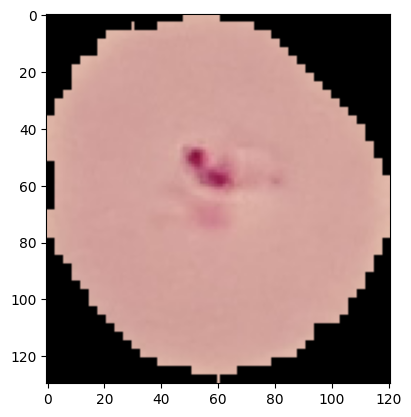

In [7]:
parasitized_dir = os.path.join(train_path, 'parasitized')
parasitized_cell = os.path.join(parasitized_dir, os.listdir(parasitized_dir)[0])
parasitized_image = imread(parasitized_cell)
plt.imshow(parasitized_image);

In [8]:
uninfected_image.shape

(115, 106, 3)

In [9]:
parasitized_image.shape

(130, 121, 3)

In [10]:
dim1 = []
dim2 = []
for image_filename in os.listdir(uninfected_dir):
    img = imread(os.path.join(uninfected_dir, image_filename))
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

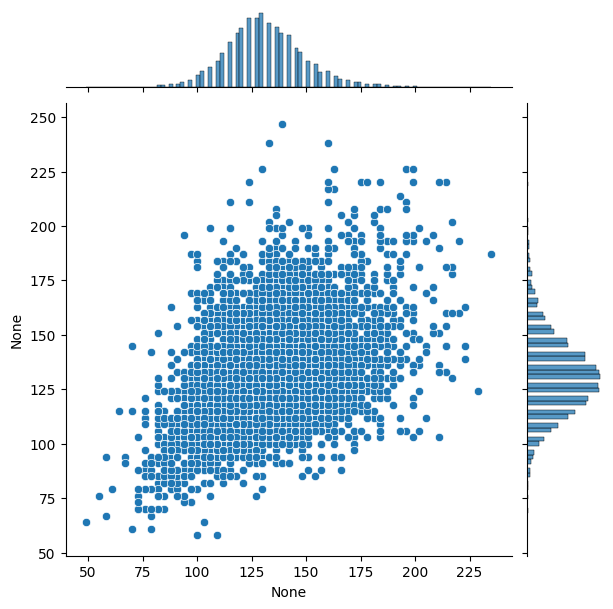

In [11]:
sns.jointplot(x=dim1, y=dim2);

In [12]:
print(np.mean(dim1))
print(np.mean(dim2))

131.64820899110507
131.4041990544114


In [13]:
image_width = 131
image_height = 131

In [14]:
parasitized_image.max()

np.float32(0.9019608)

### Data Augmentation

In [15]:
datagen = ImageDataGenerator(
    rotation_range=45,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8,1.2],
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)

In [16]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary'
)

Found 24958 images belonging to 2 classes.


In [17]:
test_generator = datagen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2600 images belonging to 2 classes.


In [18]:
train_generator.class_indices

{'parasitized': 0, 'uninfected': 1}

### Creating the Model and Training

In [23]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3)) # 75x75 recommended for EfficientNet
base_model.trainable = False

model = Sequential([
    Resizing(image_width, image_height),
    base_model,
    GlobalAveragePooling2D(),
    Dense(units=256, activation='relu'),
    Dense(units=1, activation='sigmoid')
])

In [24]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [26]:
model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=test_generator,
    validation_steps=len(test_generator),
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 86s 98ms/step - accuracy: 0.8857 - loss: 0.2708 - val_accuracy: 0.9238 - val_loss: 0.1909
Epoch 2/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.9244 - loss: 0.2009 - val_accuracy: 0.9308 - val_loss: 0.1911
Epoch 3/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.9260 - loss: 0.1945 - val_accuracy: 0.9365 - val_loss: 0.1729
Epoch 4/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.9295 - loss: 0.1800 - val_accuracy: 0.9408 - val_loss: 0.1768
Epoch 5/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.9319 - loss: 0.1738 - val_accuracy: 0.9323 - val_loss: 0.1724
Epoch 6/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 85ms/step - accuracy: 0.9339 - loss: 0.1760 - val_accuracy: 0.9354 - val_loss: 0.1611
Epoch 7/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.9356 - loss: 0.1684 - val_accuracy: 0.9415 - val_loss: 0.1635
Epoch 8/100
780/780 ━━━━━━━━━━━━━━━━━━━━ 67s 86ms/step - accuracy: 0.9414 - loss: 0

### Model Evaluation

In [27]:
history = pd.DataFrame(model.history.history)

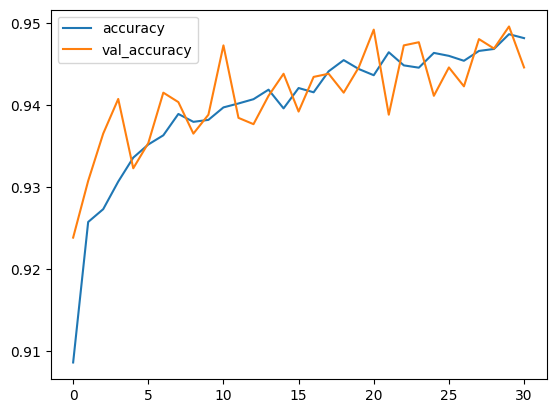

In [28]:
history[['accuracy', 'val_accuracy']].plot();

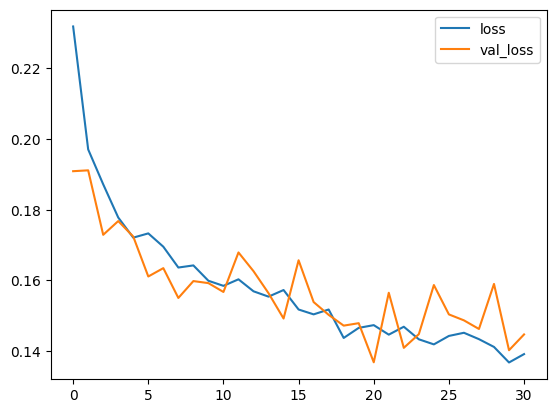

In [29]:
history[['loss', 'val_loss']].plot();

In [32]:
print(model.metrics_names)
print(model.evaluate(test_generator, verbose=0))

['loss', 'compile_metrics']
[0.15060141682624817, 0.9449999928474426]


In [36]:
predictions = (model.predict(test_generator) > 0.5).astype('int32')

82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step


In [37]:
y_true = test_generator.classes

In [38]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1300
           1       0.94      0.96      0.95      1300

    accuracy                           0.95      2600
   macro avg       0.95      0.95      0.95      2600
weighted avg       0.95      0.95      0.95      2600



### Save Model

In [33]:
model.save('malaria_model.keras')

### Predict Classes

In [40]:
malaria_model = load_model('malaria_model.keras')

In [43]:
my_image = load_img(parasitized_cell, target_size=(image_height, image_width, 3))
my_image = np.expand_dims(img_to_array(my_image), axis=0)
my_image.shape

(1, 131, 131, 3)

In [44]:
(model.predict(my_image) > 0.5).astype('int32')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


array([[0]], dtype=int32)

In [45]:
train_generator.class_indices

{'parasitized': 0, 'uninfected': 1}